In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil import parser
%matplotlib inline


from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.model_selection import GridSearchCV
import pickle


In [2]:
data= pd.read_csv('data.csv')
data.shape

(17908, 21)

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
data.head()

,entry_id,age,pay_schedule,home_owner,income,months_employed,years_employed,current_address_year,personal_account_m,personal_account_y,has_debt,amount_requested,risk_score,risk_score_2,risk_score_3,risk_score_4,risk_score_5,ext_quality_score,ext_quality_score_2,inquiries_last_month,e_signed
0,7629673,40,bi-weekly,1,3135,0,3,3,6,2,1,550,36200,0.737398,0.903517,0.487712,0.515977,0.580918,0.380918,10,1
1,3560428,61,weekly,0,3180,0,6,3,2,7,1,600,30150,0.738510,0.881027,0.713423,0.826402,0.730720,0.630720,9,0
2,6934997,23,weekly,0,1540,6,0,0,7,1,1,450,34550,0.642993,0.766554,0.595018,0.762284,0.531712,0.531712,7,0
3,5682812,40,bi-weekly,0,5230,0,6,1,2,7,1,700,42150,0.665224,0.960832,0.767828,0.778831,0.792552,0.592552,8,1
4,5335819,33,semi-monthly,0,3590,0,5,2,2,8,1,1100,53850,0.617361,0.857560,0.613487,0.665523,0.744634,0.744634,12,0


# Feature engineering

In [5]:
data.isnull().sum()

entry_id                0
age                     0
pay_schedule            0
home_owner              0
income                  0
months_employed         0
years_employed          0
current_address_year    0
personal_account_m      0
personal_account_y      0
has_debt                0
amount_requested        0
risk_score              0
risk_score_2            0
risk_score_3            0
risk_score_4            0
risk_score_5            0
ext_quality_score       0
ext_quality_score_2     0
inquiries_last_month    0
e_signed                0
dtype: int64

In [6]:
uid  = data['entry_id']
data['employed_months'] = data['months_employed'] + data['years_employed']*12

In [7]:
X = data.drop(columns=['entry_id','e_signed','months_employed','years_employed'])
Y = data['e_signed']

In [8]:
X.head()

,age,pay_schedule,home_owner,income,current_address_year,personal_account_m,personal_account_y,has_debt,amount_requested,risk_score,risk_score_2,risk_score_3,risk_score_4,risk_score_5,ext_quality_score,ext_quality_score_2,inquiries_last_month,employed_months
0,40,bi-weekly,1,3135,3,6,2,1,550,36200,0.737398,0.903517,0.487712,0.515977,0.580918,0.380918,10,36
1,61,weekly,0,3180,3,2,7,1,600,30150,0.738510,0.881027,0.713423,0.826402,0.730720,0.630720,9,72
2,23,weekly,0,1540,0,7,1,1,450,34550,0.642993,0.766554,0.595018,0.762284,0.531712,0.531712,7,6
3,40,bi-weekly,0,5230,1,2,7,1,700,42150,0.665224,0.960832,0.767828,0.778831,0.792552,0.592552,8,72
4,33,semi-monthly,0,3590,2,2,8,1,1100,53850,0.617361,0.857560,0.613487,0.665523,0.744634,0.744634,12,60


In [9]:
X.describe()

,age,home_owner,income,current_address_year,personal_account_m,personal_account_y,has_debt,amount_requested,risk_score,risk_score_2,risk_score_3,risk_score_4,risk_score_5,ext_quality_score,ext_quality_score_2,inquiries_last_month,employed_months
count,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000
mean,43.015412,0.425173,3657.214653,3.584711,3.427183,3.503350,0.795399,950.446449,61086.302211,0.690878,0.878276,0.583155,0.718252,0.623112,0.622068,6.457226,43.508320
std,11.873107,0.494383,1504.890063,2.751937,2.216440,1.955568,0.403421,698.543683,15394.255020,0.090470,0.054563,0.125061,0.120697,0.139729,0.139898,3.673093,26.765085
min,18.000000,0.000000,905.000000,0.000000,0.000000,0.000000,0.000000,350.000000,2100.000000,0.023258,0.451371,0.016724,0.153367,0.010184,0.006622,1.000000,0.000000
25%,34.000000,0.000000,2580.000000,2.000000,2.000000,2.000000,1.000000,600.000000,49350.000000,0.640993,0.850882,0.500208,0.633708,0.521735,0.519677,4.000000,24.000000
50%,42.000000,0.000000,3260.000000,3.000000,2.000000,3.000000,1.000000,700.000000,61200.000000,0.699561,0.881004,0.588208,0.725113,0.625944,0.622974,6.000000,36.000000
75%,51.000000,1.000000,4670.000000,5.000000,5.000000,4.000000,1.000000,1100.000000,72750.000000,0.752887,0.912608,0.672395,0.806681,0.729841,0.728940,8.000000,60.000000
max,96.000000,1.000000,9985.000000,12.000000,11.000000,15.000000,1.000000,10200.000000,99750.000000,0.999997,0.999024,0.978932,0.996260,0.970249,0.966953,30.000000,201.000000


# Visualization

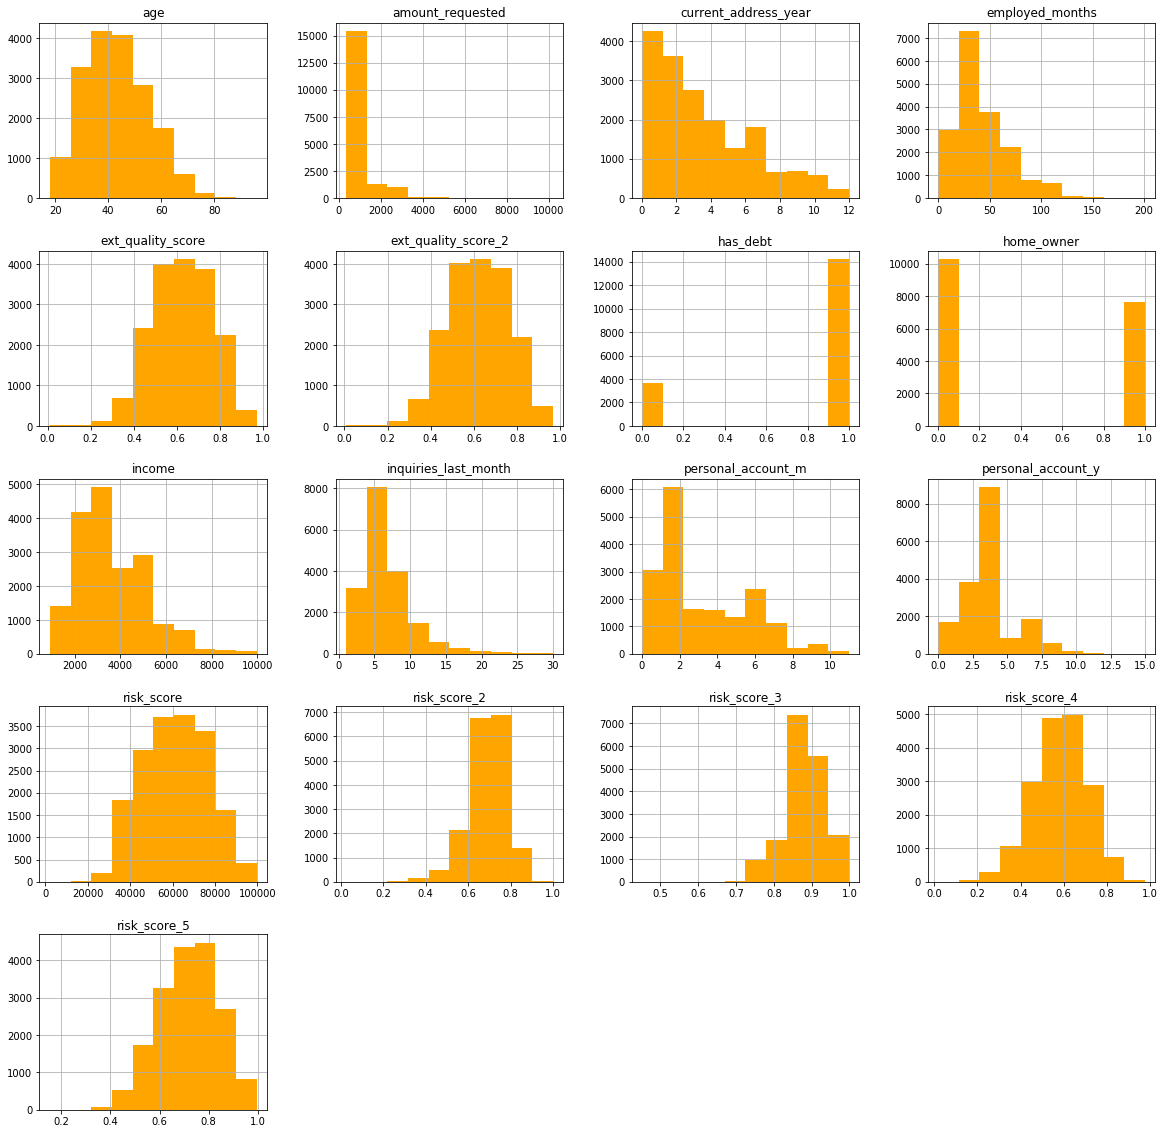

In [22]:
X.hist(figsize=(20,20),color='orange')
plt.show()


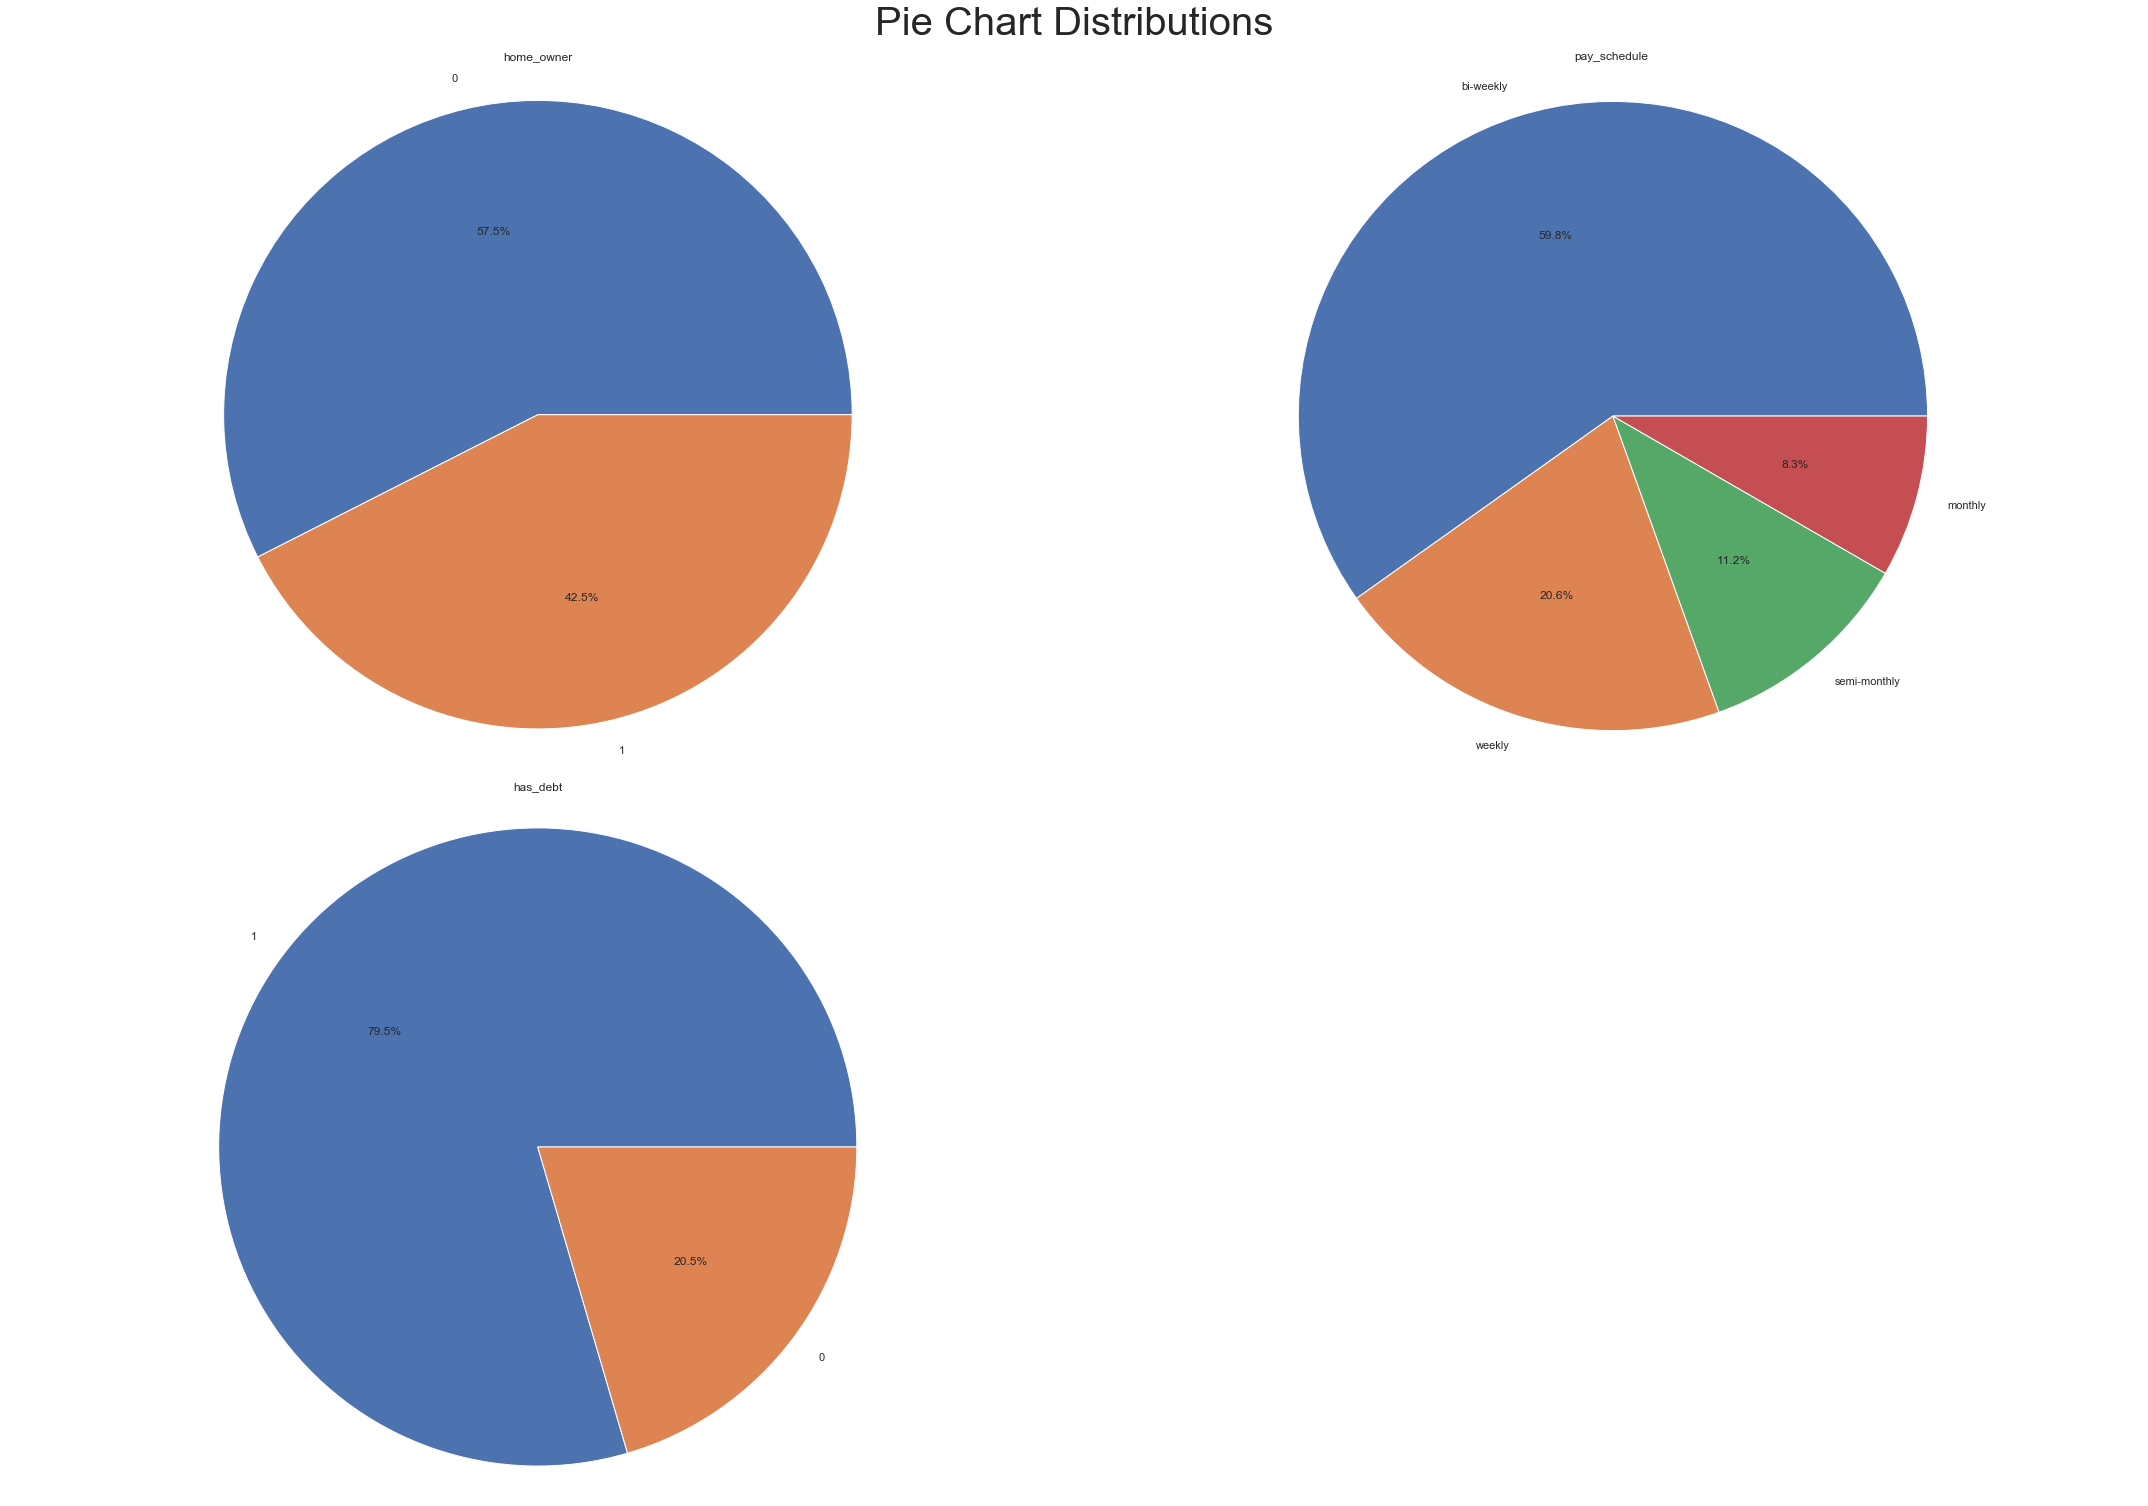

In [29]:
## Pie Plots
dataset2 = X[['home_owner', 'pay_schedule', 'has_debt']]
fig = plt.figure(figsize=(30, 22))
plt.suptitle('Pie Chart Distributions', fontsize=40)
for i in range(1, dataset2.shape[1] + 1):
    plt.subplot(2, 2, i)
    f = plt.gca()
    f.axes.get_yaxis().set_visible(False)
    f.set_title(dataset2.columns.values[i - 1])
   
    values = dataset2.iloc[:, i - 1].value_counts(normalize = True).values
    index = dataset2.iloc[:, i - 1].value_counts(normalize = True).index
    plt.pie(values, labels = index, autopct='%1.1f%%')
    plt.axis('equal')
fig.tight_layout(rect=[0, 0.03, 1, 0.96])

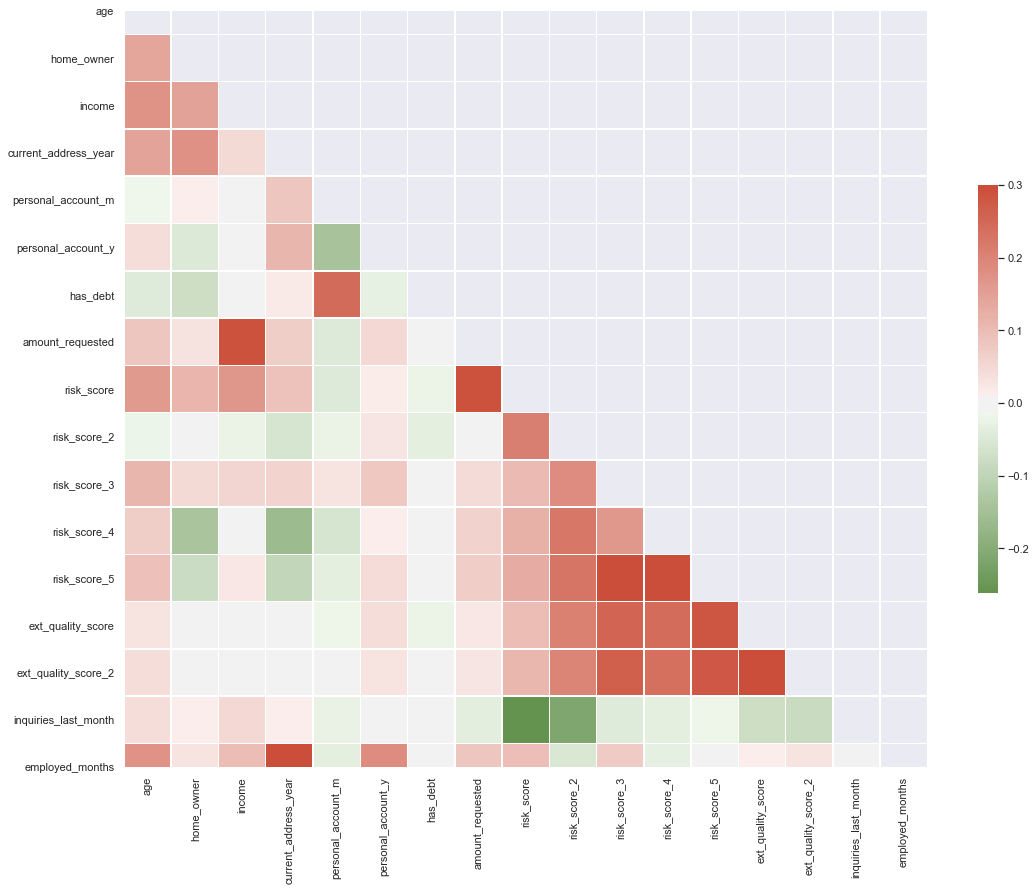

In [23]:
## Correlation Matrix
sns.set(style="dark")

# Compute the correlation matrix
corr = X.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(18, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(120, 17, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [10]:
X.head()

,age,pay_schedule,home_owner,income,current_address_year,personal_account_m,personal_account_y,has_debt,amount_requested,risk_score,risk_score_2,risk_score_3,risk_score_4,risk_score_5,ext_quality_score,ext_quality_score_2,inquiries_last_month,employed_months
0,40,bi-weekly,1,3135,3,6,2,1,550,36200,0.737398,0.903517,0.487712,0.515977,0.580918,0.380918,10,36
1,61,weekly,0,3180,3,2,7,1,600,30150,0.738510,0.881027,0.713423,0.826402,0.730720,0.630720,9,72
2,23,weekly,0,1540,0,7,1,1,450,34550,0.642993,0.766554,0.595018,0.762284,0.531712,0.531712,7,6
3,40,bi-weekly,0,5230,1,2,7,1,700,42150,0.665224,0.960832,0.767828,0.778831,0.792552,0.592552,8,72
4,33,semi-monthly,0,3590,2,2,8,1,1100,53850,0.617361,0.857560,0.613487,0.665523,0.744634,0.744634,12,60


# one-hot encoding

In [10]:

X = pd.get_dummies(X)
X.head()

,age,home_owner,income,current_address_year,personal_account_m,personal_account_y,has_debt,amount_requested,risk_score,risk_score_2,risk_score_3,risk_score_4,risk_score_5,ext_quality_score,ext_quality_score_2,inquiries_last_month,employed_months,pay_schedule_bi-weekly,pay_schedule_monthly,pay_schedule_semi-monthly,pay_schedule_weekly
0,40,1,3135,3,6,2,1,550,36200,0.737398,0.903517,0.487712,0.515977,0.580918,0.380918,10,36,1,0,0,0
1,61,0,3180,3,2,7,1,600,30150,0.738510,0.881027,0.713423,0.826402,0.730720,0.630720,9,72,0,0,0,1
2,23,0,1540,0,7,1,1,450,34550,0.642993,0.766554,0.595018,0.762284,0.531712,0.531712,7,6,0,0,0,1
3,40,0,5230,1,2,7,1,700,42150,0.665224,0.960832,0.767828,0.778831,0.792552,0.592552,8,72,1,0,0,0
4,33,0,3590,2,2,8,1,1100,53850,0.617361,0.857560,0.613487,0.665523,0.744634,0.744634,12,60,0,0,1,0


In [11]:

X.drop(labels='pay_schedule_bi-weekly',inplace=True,axis=1)
col = X.columns
X.shape

(17908, 20)

# feature scaling

In [12]:
SS = StandardScaler()
X = SS.fit_transform(X)

In [13]:
X = pd.DataFrame(X)
X.columns = col
X.head()

,age,home_owner,income,current_address_year,personal_account_m,personal_account_y,has_debt,amount_requested,risk_score,risk_score_2,risk_score_3,risk_score_4,risk_score_5,ext_quality_score,ext_quality_score_2,inquiries_last_month,employed_months,pay_schedule_monthly,pay_schedule_semi-monthly,pay_schedule_weekly
0,-0.253977,1.162748,-0.347022,-0.212478,1.160820,-0.768775,0.50718,-0.573275,-1.616642,0.514223,0.462623,-0.763184,-1.675935,-0.301983,-1.723802,0.964548,-0.280535,-0.301475,-0.354973,-0.509963
1,1.514775,-0.860031,-0.317118,-0.212478,-0.643926,1.788098,0.50718,-0.501696,-2.009657,0.526513,0.050418,1.041669,0.896068,0.770140,0.061845,0.692290,1.064539,-0.301475,-0.354973,1.960928
2,-1.685824,-0.860031,-1.406929,-1.302650,1.612007,-1.280150,0.50718,-0.716434,-1.723828,-0.529297,-2.047629,0.094863,0.364822,-0.654147,-0.645889,0.147774,-1.401429,-0.301475,-0.354973,1.960928
3,-0.253977,-0.860031,1.045146,-0.939260,-0.643926,1.788098,0.50718,-0.358537,-1.230123,-0.283571,1.513086,1.476706,0.501921,1.212668,-0.210989,0.420032,1.064539,-0.301475,-0.354973,-0.509963
4,-0.843561,-0.860031,-0.044665,-0.575869,-0.643926,2.299472,0.50718,0.214099,-0.470078,-0.812623,-0.379682,0.242545,-0.436878,0.869722,0.876131,1.509063,0.616181,-0.301475,2.817113,-0.509963


# Balancing the data 

In [14]:
Y.value_counts()

1    9639
0    8269
Name: e_signed, dtype: int64

In [15]:
from imblearn.over_sampling import SMOTE

Using TensorFlow backend.


In [16]:
SE = SMOTE(random_state=42,ratio=1)
X_resampled , Y_resample = SE.fit_resample(X,Y)
pd.Series(Y_resample).value_counts()

1    9639
0    9639
dtype: int64

In [17]:
X_resampled.shape

(19278, 20)

# Model Fitting 

In [18]:
# Functionalize model fittting

def FitModel(X,Y,algo_name,algorithm,gridSearchParams,cv):
    np.random.seed(10)
    x_train,x_test,y_train,y_test = train_test_split(X,Y, test_size = 0.2)
    
    
    grid = GridSearchCV(
        estimator=algorithm,
        param_grid=gridSearchParams,
        cv=cv, scoring='accuracy', verbose=1, n_jobs=-1)
    
    
    grid_result = grid.fit(x_train, y_train)
    best_params = grid_result.best_params_
    pred = grid_result.predict(x_test)
    cm = confusion_matrix(y_test, pred)
   # metrics =grid_result.gr
    print(pred)
    #pickle.dump(grid_result,open(algo_name,'wb'))
   
    print('Best Params :',best_params)
    print('Classification Report :',classification_report(y_test,pred))
    print('Accuracy Score : ' + str(accuracy_score(y_test,pred)))
    print('Confusion Matrix : \n', cm)

# Logistic Regression

In [61]:
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

FitModel(X_resampled,Y_resample,'LogisticRegression_OB',LogisticRegression(),hyperparameters,cv=5)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s


[0 1 0 ... 1 0 1]
Best Params : {'C': 7.742636826811269, 'penalty': 'l1'}
Classification Report :               precision    recall  f1-score   support

           0       0.58      0.58      0.58      1904
           1       0.59      0.59      0.59      1952

    accuracy                           0.58      3856
   macro avg       0.58      0.58      0.58      3856
weighted avg       0.58      0.58      0.58      3856

Accuracy Score : 0.5840248962655602
Confusion Matrix : 
 [[1108  796]
 [ 808 1144]]


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.8s finished
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [68]:
 np.logspace(0, 4, 10)

array([1.00000000e+00, 2.78255940e+00, 7.74263683e+00, 2.15443469e+01,
       5.99484250e+01, 1.66810054e+02, 4.64158883e+02, 1.29154967e+03,
       3.59381366e+03, 1.00000000e+04])

# Random Forest

In [67]:
param ={
            'n_estimators': [100, 500, 1000, 2000],
           
        }
FitModel(X_resampled,Y_resample,'Random Forest_OS',RandomForestClassifier(),param,cv=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.5min finished


[0 0 0 ... 1 0 0]
Best Params : {'n_estimators': 2000}
Classification Report :               precision    recall  f1-score   support

           0       0.66      0.70      0.68      1904
           1       0.69      0.65      0.67      1952

    accuracy                           0.67      3856
   macro avg       0.67      0.67      0.67      3856
weighted avg       0.67      0.67      0.67      3856

Accuracy Score : 0.6740145228215768
Confusion Matrix : 
 [[1324  580]
 [ 677 1275]]


# SVC

In [20]:
param ={
            'C': [0.1, 1, 100, 1000],
            'gamma': [0.0001, 0.001, 0.005, 0.1, 1, 3, 5]
        }
FitModel(X_resampled,Y_resample,'SVC_OS',SVC(),param,cv=5)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed: 10.8min finished


[0 0 0 ... 0 0 0]
Best Params : {'C': 1, 'gamma': 0.1}
Classification Report :               precision    recall  f1-score   support

           0       0.62      0.66      0.64      1904
           1       0.65      0.60      0.62      1952

    accuracy                           0.63      3856
   macro avg       0.63      0.63      0.63      3856
weighted avg       0.63      0.63      0.63      3856

Accuracy Score : 0.6322614107883817
Confusion Matrix : 
 [[1258  646]
 [ 772 1180]]


# XGBoost

In [22]:
param ={
            'n_estimators': [100, 500, 1000, 2000],
            'max_depth':[2,3,4,5,6]
           
        }
FitModel(X_resampled,Y_resample,'XGBoost_OS',XGBClassifier(),param,cv=5)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  7.2min finished


[0 0 0 ... 0 0 0]
Best Params : {'max_depth': 3, 'n_estimators': 500}
Classification Report :               precision    recall  f1-score   support

           0       0.66      0.67      0.67      1904
           1       0.67      0.66      0.67      1952

    accuracy                           0.67      3856
   macro avg       0.67      0.67      0.67      3856
weighted avg       0.67      0.67      0.67      3856

Accuracy Score : 0.66701244813278
Confusion Matrix : 
 [[1282  622]
 [ 662 1290]]


# LightGBM

In [23]:
from lightgbm import LGBMClassifier

In [27]:

params = {}
params['learning_rate'] = [0.003,0.001,0.03,0.01,0.3,0.1]
params['max_depth'] = [5,10,15,20]
params['n_estimators']= [100, 500, 1000, 2000]

FitModel(X_resampled,Y_resample,'LightGBM_OS',LGBMClassifier(objective='binary',boosting_type='gbdt'),params,cv=5)





Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  6.5min finished


[0 0 0 ... 1 0 0]
Best Params : {'learning_rate': 0.03, 'max_depth': 10, 'n_estimators': 500}
Classification Report :               precision    recall  f1-score   support

           0       0.66      0.67      0.66      1904
           1       0.67      0.66      0.67      1952

    accuracy                           0.67      3856
   macro avg       0.67      0.67      0.67      3856
weighted avg       0.67      0.67      0.67      3856

Accuracy Score : 0.6651970954356846
Confusion Matrix : 
 [[1278  626]
 [ 665 1287]]


# CatBoost

In [21]:
from catboost import CatBoostClassifier

In [22]:
params = {}
params['learning_rate'] = [0.003,0.001,0.03,0.01,0.3,0.1]
params['depth'] = [2,5,10,16]

FitModel(X_resampled,Y_resample,'CatBoost_OS',CatBoostClassifier(iterations=100),params,cv=5)


Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 126.9min finished


0:	learn: 0.6809181	total: 120ms	remaining: 11.8s
1:	learn: 0.6702964	total: 126ms	remaining: 6.17s
2:	learn: 0.6605786	total: 132ms	remaining: 4.27s
3:	learn: 0.6571764	total: 138ms	remaining: 3.31s
4:	learn: 0.6491898	total: 143ms	remaining: 2.72s
5:	learn: 0.6446842	total: 162ms	remaining: 2.53s
6:	learn: 0.6421597	total: 169ms	remaining: 2.25s
7:	learn: 0.6392608	total: 177ms	remaining: 2.04s
8:	learn: 0.6345635	total: 185ms	remaining: 1.87s
9:	learn: 0.6312463	total: 195ms	remaining: 1.75s
10:	learn: 0.6286183	total: 222ms	remaining: 1.79s
11:	learn: 0.6256342	total: 254ms	remaining: 1.86s
12:	learn: 0.6231607	total: 265ms	remaining: 1.77s
13:	learn: 0.6191280	total: 304ms	remaining: 1.87s
14:	learn: 0.6172801	total: 312ms	remaining: 1.77s
15:	learn: 0.6141276	total: 318ms	remaining: 1.67s
16:	learn: 0.6127356	total: 326ms	remaining: 1.59s
17:	learn: 0.6110896	total: 333ms	remaining: 1.51s
18:	learn: 0.6090278	total: 347ms	remaining: 1.48s
19:	learn: 0.6061998	total: 354ms	remaini